# **ODRA Quantum Computing Workshop - 17.09.2025**
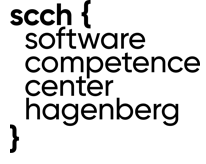

# Qiskit basics

required Python packages:

`pip install qiskit[visualization] qiskit-ibm-runtime qiskit-aer`

In [20]:
from qiskit import QuantumCircuit, transpile
from qiskit_aer import AerSimulator
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit_ibm_runtime.fake_provider import FakeManilaV2
from qiskit.visualization import plot_histogram

## We build our first quantum circuit

The circuit works with 2 qubits and should create the entangled state $\frac{1}{\sqrt{2}} ( \ket{00} + \ket{11})$. 

For this we use a Hadamard gate on the first qubit and then a CNOT gate on both qubits, with the first one being the control qubit and the second one the target qubit. 

The prepared state is then measured.

If one wants to proof that this circuit creates the state we are interested in, the matrix representation of the gates can be used:

$$ \operatorname{H} = \frac{1}{\sqrt{2}} \begin{bmatrix} 1 & 1 \\ 1 & -1 \end{bmatrix} \qquad \operatorname{CNOT} = \begin{bmatrix}1&0&0&0\\0&1&0&0\\0&0&0&1\\0&0&1&0\end{bmatrix}$$

In [21]:
circuit = QuantumCircuit(2)

circuit.h(0)
circuit.cx(0, 1)
circuit.measure_all()

We can also visualize the circuit

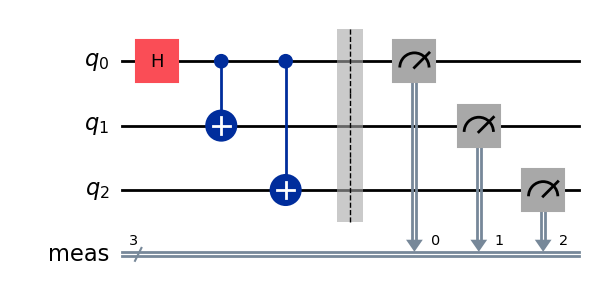

In [22]:
circuit.draw(output='mpl')

## Running a circuit

We have multiple options to run a quantum circuit with qiskit. We can choose to **simulate** the quantum circuit on a **classical computer** or to send the circuit to an actual **quantum hardware at IBM**. 

When simulating the circuit we can either run it **locally** on our own machine or use **IBM's simulator cloud service**. 

It is also important to be able to run simulations that are very close to the actual quantum hardware, thus also simulating the **noise and errors** of the real quantum hardware - we can choose between an **ideal simulator** or a simulator with a specific **noise model**.

In this tutorial we will perform the following executions of our simple quantum circuit:
- ideal simulation, local
- noisy simulation, local
- ideal simulation, cloud service
- quantum hardware


## 1. Let's start with the ideal simulation

Remember, our circuit prepares the state $\frac{1}{\sqrt{2}} ( \ket{00} + \ket{11})$, so when we measure the quantum state at the end of the circuit we expect to get the result $\ket{00}$ or $\ket{11}$ with $50\%$ each. The states $\ket{01}$ or $\ket{10}$ have zero probability to be found. 

Since a single measurement does not tell us very much about the quantum state, we have to repeat the circuit several times and build statistics of the obtained results.

How often the circuit is repeated is specified by the so called **shots** and we will use `num_shots=10000` for our examples.

To run an ideal simulation on the local machine we just need to use the qiskit `AerSimulator` and provide it with the `QuantumCircuit`.

Counts(ideal): {'111': 5005, '000': 4995}


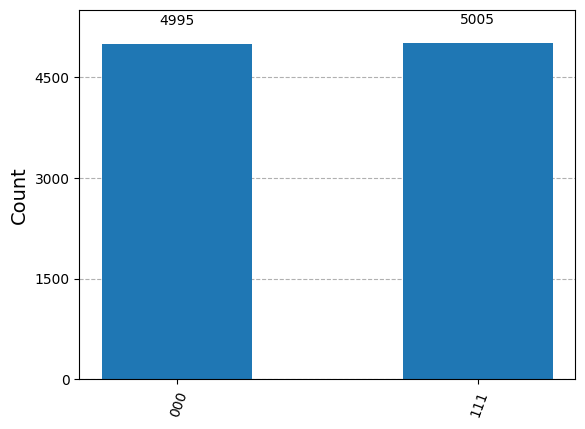

In [23]:
sim_ideal = AerSimulator()

num_shots = 10000
result_ideal = sim_ideal.run(circuit, shots=num_shots).result()
counts_ideal = result_ideal.get_counts(0)
print('Counts(ideal):', counts_ideal)
plot_histogram(counts_ideal)

## 2. run a realistic noisy simulation

We will use the a noise model for an actual quantum computer, the machine `ibm_brisbane`. For this we need to connect to the `QiskitRuntimeService` and load the simulation backend.

Note: this requires an IBM account, https://quantum.ibm.com/, additional info available at https://docs.quantum.ibm.com/start/setup-channel

station-control-client version '9.8.0' is newer minor version than '9.4.0' used by the station control server, some new client features might not be supported.
/home/xederro/.pyenv/versions/3.11.13/lib/python3.11/site-packages/qiskit_aer/noise/noise_model.py:376: UserWarning: Qiskit backend <iqm.qiskit_iqm.iqm_provider.IQMBackend object at 0x7f5f10947810> has no QubitProperties, so the resulting noise model will not include any thermal relaxation errors.
  warn(


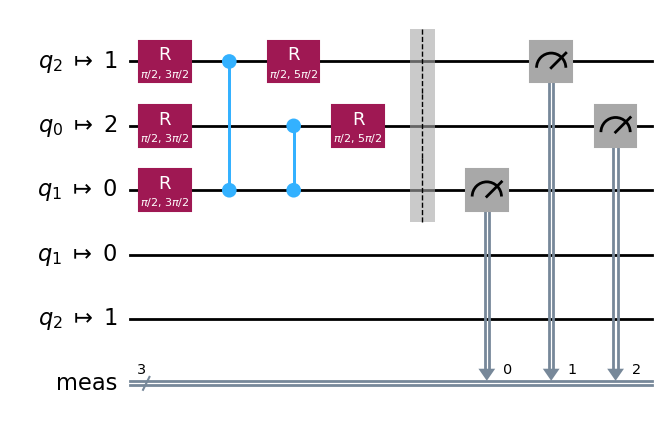

In [26]:
backend = FakeManilaV2()
sim_noise = AerSimulator.from_backend(backend)


transpiled_circuit = transpile(circuit, backend)
transpiled_circuit.draw('mpl', style="iqp")

The simulation is then performed locally with the noise model provided from IBM.

In the count statistics we can now see that also the $\ket{01}$ and $\ket{10}$ state has been measured. This is due to the noise model included in the simulation which should reflect the behaviour of the actual quantum hardware.

Counts(noise): {'111': 4224, '000': 4532, '010': 350, '011': 161, '110': 143, '100': 67, '101': 503, '001': 20}


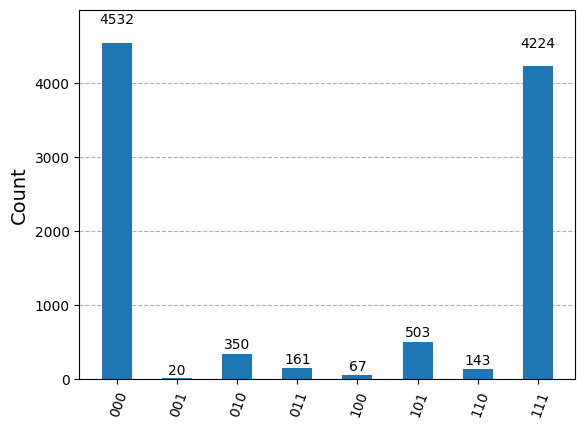

In [30]:
result_noise = sim_noise.run(transpiled_circuit, shots=num_shots).result()
counts_noise = result_noise.get_counts(0)
print('Counts(noise):', counts_noise)
plot_histogram(counts_noise)

## 3. use the IBM simulator cloud service

This method actually sends our circuit to the IBM computer servers. This is essential when simulating larger circuits, since our personal hardware cannot handle large ciruits. IBM uses GPU clusters to perform the simulations.

We do not specify to use a noise model here, so the results are again ideal.

IBM provides a dashboard at https://quantum.ibm.com/ to see all submitted jobs.

In [14]:
service = QiskitRuntimeService(channel="ibm_cloud")
backend = service.backends()

print(backend)

# result_ibm = backend.run(circuit, shots=num_shots).result()
# counts_ibm = result_ibm.get_counts(0)
# print('Counts(ibm):', counts_ibm)
# plot_histogram(counts_ibm)

AccountNotFoundError: "Unable to find account. Please make sure an account with the channel name 'ibm_cloud' is saved."

## 4. Now we use real quantum hardware!!

We will choose the least busy quantum computing device at IBM.

In [13]:
backend_quantum = service.least_busy(simulator=False, operational=True)
backend_quantum

NameError: name 'service' is not defined

The next important step is to compile the quantum circuit into an ISA circuit (instruction set architecture) that can be executed on the quantum hardware. The reason for this is, that different quantum hardware has a different set of basic quantum gates that it can execute. We will do this with the following code and will also visualize the compiled circuit.

In [12]:
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

pm = generate_preset_pass_manager(backend=backend_quantum, optimization_level=1)
isa_circuit = pm.run(circuit)
isa_circuit.draw(output='mpl')

NameError: name 'backend_quantum' is not defined

We will now send this ISA circuit to the actual quantum hardware. To not waste too much of the free quantum computing time (10 min/month) we just use 1000 shots for this run.

In [ ]:
from qiskit_ibm_runtime import SamplerV2 as Sampler

sampler = Sampler(backend_quantum)
runOnQuantumHardware = True
if runOnQuantumHardware:
    job = sampler.run([(isa_circuit,)], shots=1000)

We can now go to the dasboard and check the status of our submission https://quantum.ibm.com/

For larger circuits there is often a waiting time. So it is better to do not block our development environment and fetch the result once the quantum hardware has executed our circuit. The dashboard provides a unique identifier to fetch the simulation results.

In [ ]:
job = service.job('d34k2v50qhlc73crjgo0')
job_result = job.result(timeout=30)
counts_quantum = job_result[0].data.meas.get_counts()
print('Counts(ibm):', counts_quantum)
plot_histogram(counts_quantum)

## Further resources for experimenting with simple quantum circuits

- Graphical circuit builder https://quantum.ibm.com/composer
- Online Python Notebook editor with qiskit installed https://lab.quantum.ibm.com/
- Qiskit tutorials https://learning.quantum.ibm.com/
- Qiskit textbook https://github.com/Qiskit/textbook/tree/main (a collection of Jupyter Notebooks with examples for several quantum algorithms)